# SwellSight Wave Analysis Model - Model Training Pipeline

This notebook implements the multi-task model training pipeline for wave analysis using both real and synthetic data.

## Overview
- Load configuration and synthetic generation results
- Prepare training dataset with real and synthetic images
- Initialize multi-task wave analysis model
- Implement training pipeline with validation
- Monitor training progress and metrics
- Save trained model checkpoints

## Prerequisites
- Complete execution of `05_ControlNet_Synthetic_Generation.ipynb`
- Synthetic images and real images available
- GPU access recommended for model training

---

## 1. Load Configuration and Previous Results

In [4]:
import sys
from pathlib import Path

# Check if running in Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    print("Mounting Google Drive...")

    try:
        drive.mount('/content/drive')
        print("✓ Google Drive mounted successfully")
    except Exception as e:
        try:
            drive.mount('/content/drive', force_remount=True, timeout_ms=300000)
            print("✓ Force remount successful")
        except Exception as e2:
            print(f"❌ Critical failure mounting drive: {e2}")
            raise

    PROJECT_PATH = Path('/content/drive/MyDrive/SwellSight')
    if PROJECT_PATH.exists():
        print(f"✓ Project directory found: {PROJECT_PATH}")
    else:
        print(f"⚠️ Project directory not found at: {PROJECT_PATH}")
else:
    print("Not running in Google Colab. Skipping Drive mount.")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully
✓ Project directory found: /content/drive/MyDrive/SwellSight


In [5]:
import sys
import os
import json
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Check environment
IN_COLAB = 'google.colab' in sys.modules

# Load configuration and previous results
try:
    CONFIG = globals().get('SWELLSIGHT_CONFIG')
    SYNTHETIC_GENERATION_DATA = globals().get('SYNTHETIC_GENERATION_DATA')
    logger = globals().get('SWELLSIGHT_LOGGER')

    if CONFIG is None:
        # Updated config file path
        config_file = Path('/content/drive/MyDrive/SwellSight/data/metadata/pipeline_config.json') if IN_COLAB else Path('SwellSight/data/metadata/pipeline_config.json')
        with open(config_file, 'r') as f:
            CONFIG = json.load(f)

    if SYNTHETIC_GENERATION_DATA is None:
        synthetic_file = Path(CONFIG['paths']['metadata_path']) / 'controlnet_generation_results.json'
        if synthetic_file.exists():
            with open(synthetic_file, 'r') as f:
                SYNTHETIC_GENERATION_DATA = json.load(f)
        else:
            synthetic_file = Path(CONFIG['paths']['metadata_path']) / 'synthetic_generation_results.json'
            if synthetic_file.exists():
                with open(synthetic_file, 'r') as f:
                    SYNTHETIC_GENERATION_DATA = json.load(f)
            else:
                print("⚠️  No synthetic generation data found. Using placeholder.")
                SYNTHETIC_GENERATION_DATA = {'ready_for_training': False, 'synthetic_results': []}

    print(f"✓ Configuration and synthetic data loaded")
    print(f"  Available synthetic images: {len(SYNTHETIC_GENERATION_DATA.get('synthetic_results', []))}")
    print(f"  Ready for training: {SYNTHETIC_GENERATION_DATA.get('ready_for_training', False)}")

except Exception as e:
    print(f"❌ Failed to load configuration: {e}")
    raise

✓ Configuration and synthetic data loaded
  Available synthetic images: 50
  Ready for training: True


The `SYNTHETIC_GENERATION_DATA` variable stores the results of the synthetic image generation process. The number of synthetic images available for training is determined by the length of the `synthetic_results` list within this variable. Let's inspect it:

In [6]:
print(f"SYNTHETIC_GENERATION_DATA['synthetic_results'] length: {len(SYNTHETIC_GENERATION_DATA.get('synthetic_results', []))}")
if 'total_synthetic_generated' in SYNTHETIC_GENERATION_DATA:
    print(f"Total synthetic images generated (as per metadata): {SYNTHETIC_GENERATION_DATA['total_synthetic_generated']}")
if 'summary' in SYNTHETIC_GENERATION_DATA and 'processing_results' in SYNTHETIC_GENERATION_DATA['summary']:
    print(f"Successful generations (as per summary): {SYNTHETIC_GENERATION_DATA['summary']['processing_results'].get('successful_generations', 'N/A')}")

# Display the first few synthetic results entries for context
print("\nFirst 3 synthetic results entries:")
for i, result in enumerate(SYNTHETIC_GENERATION_DATA.get('synthetic_results', [])[:3]):
    print(f"  Entry {i+1}: Image Path: {result.get('synthetic_image_path')}, Ready for Training: {result.get('ready_for_training')}")

SYNTHETIC_GENERATION_DATA['synthetic_results'] length: 50
Total synthetic images generated (as per metadata): 50
Successful generations (as per summary): 50

First 3 synthetic results entries:
  Entry 1: Image Path: /content/drive/MyDrive/SwellSight/data/synthetic/images/beach_001_synthetic_000.jpg, Ready for Training: None
  Entry 2: Image Path: /content/drive/MyDrive/SwellSight/data/synthetic/images/beach_001_synthetic_001.jpg, Ready for Training: None
  Entry 3: Image Path: /content/drive/MyDrive/SwellSight/data/synthetic/images/beach_001_synthetic_002.jpg, Ready for Training: None


## 2. Multi-Task Wave Analysis Model

In [7]:
class WaveAnalysisModel(nn.Module):
    """
    Multi-task wave analysis model for beach camera images.

    Predicts multiple wave characteristics simultaneously:
    - Wave height estimation
    - Breaking type classification
    - Wave quality assessment
    - Foam coverage estimation
    """

    def __init__(self, input_channels=3, num_breaking_types=4):
        super(WaveAnalysisModel, self).__init__()

        # Shared feature extractor (CNN backbone)
        self.feature_extractor = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth conv block
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        # Shared fully connected layers
        self.shared_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        # Task-specific heads
        # Wave height regression (0-5 meters)
        self.wave_height_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output 0-1, scale to 0-5m
        )

        # Breaking type classification
        self.breaking_type_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_breaking_types)  # spilling, plunging, collapsing, surging
        )

        # Wave quality score (0-1)
        self.quality_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        # Foam coverage percentage (0-100%)
        self.foam_coverage_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output 0-1, scale to 0-100%
        )

    def forward(self, x):
        # Extract shared features
        features = self.feature_extractor(x)
        shared_features = self.shared_fc(features)

        # Task-specific predictions
        # Ensure scaling factors are float32 tensors and on the same device as the model
        wave_height_scale = torch.tensor(5.0, dtype=torch.float32).to(x.device)
        foam_coverage_scale = torch.tensor(100.0, dtype=torch.float32).to(x.device)

        wave_height = self.wave_height_head(shared_features) * wave_height_scale
        breaking_type = self.breaking_type_head(shared_features)
        quality_score = self.quality_head(shared_features)
        foam_coverage = self.foam_coverage_head(shared_features) * foam_coverage_scale

        return {
            'wave_height': wave_height,
            'breaking_type': breaking_type,
            'quality_score': quality_score,
            'foam_coverage': foam_coverage
        }

print("✓ WaveAnalysisModel defined")

✓ WaveAnalysisModel defined


## 3. Dataset and Data Loading

In [8]:
class WaveAnalysisDataset(Dataset):
    """
    Dataset for wave analysis training combining real and synthetic images.
    """

    def __init__(self, image_paths, labels, transform=None, image_size=(224, 224)):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.image_size = image_size

        # Default transform if none provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Get labels
        label_dict = self.labels[idx]

        # Convert labels to tensors with appropriate dtypes
        target_tensors = {
            'wave_height': torch.tensor(label_dict['wave_height'], dtype=torch.float32),
            'breaking_type': torch.tensor(label_dict['breaking_type'], dtype=torch.long),
            'quality_score': torch.tensor(label_dict['quality_score'], dtype=torch.float32),
            'foam_coverage': torch.tensor(label_dict['foam_coverage'], dtype=torch.float32)
        }

        return image, target_tensors

def prepare_training_data():
    """
    Prepare training data from real and synthetic images.
    """
    print("Preparing training data...")

    image_paths = []
    labels = []

    # Add synthetic images if available
    if SYNTHETIC_GENERATION_DATA.get('ready_for_training', False):
        synthetic_results = SYNTHETIC_GENERATION_DATA['synthetic_results']

        for result in synthetic_results:
            image_paths.append(result['synthetic_image_path'])

            # Extract labels from augmentation parameters
            aug_params = result['augmentation_params']

            # Convert breaking type to index
            breaking_types = ['spilling', 'plunging', 'collapsing', 'surging']
            breaking_type_idx = breaking_types.index(aug_params.get('breaking_type', 'spilling'))

            label = {
                'wave_height': float(aug_params.get('dominant_wave_height_m', 1.5)),
                'breaking_type': breaking_type_idx,
                'quality_score': float(result.get('quality_score', 0.7)),
                'foam_coverage': float(aug_params.get('foam_coverage_pct', 30.0))
            }

            labels.append(label)

    # Add real images with estimated labels (placeholder)
    real_images_path = Path(CONFIG['paths']['real_images_path'])
    if real_images_path.exists():
        real_image_files = list(real_images_path.glob('*.jpg')) + list(real_images_path.glob('*.png'))

        for image_path in real_image_files[:10]:  # Limit real images for demo
            image_paths.append(str(image_path))

            # Placeholder labels for real images (would need manual annotation)
            label = {
                'wave_height': np.random.uniform(0.5, 3.0),
                'breaking_type': np.random.randint(0, 4),
                'quality_score': np.random.uniform(0.5, 0.9),
                'foam_coverage': np.random.uniform(10.0, 60.0)
            }

            labels.append(label)

    print(f"✓ Prepared {len(image_paths)} training samples")
    print(f"  Synthetic images: {len(SYNTHETIC_GENERATION_DATA.get('synthetic_results', []))}")
    print(f"  Real images: {len(image_paths) - len(SYNTHETIC_GENERATION_DATA.get('synthetic_results', []))}")

    return image_paths, labels

# Prepare the actual training data
image_paths, labels = prepare_training_data()
print("✓ Dataset classes defined")

Preparing training data...
✓ Prepared 60 training samples
  Synthetic images: 50
  Real images: 10
✓ Dataset classes defined


## 4. Training Pipeline Implementation

In [9]:
def create_data_loaders(image_paths, labels, train_split=0.8, batch_size=16):
    """
    Create training and validation data loaders.
    """
    # Split data
    split_idx = int(len(image_paths) * train_split)

    train_paths = image_paths[:split_idx]
    train_labels = labels[:split_idx]
    val_paths = image_paths[split_idx:]
    val_labels = labels[split_idx:]

    # Create datasets
    train_dataset = WaveAnalysisDataset(train_paths, train_labels)
    val_dataset = WaveAnalysisDataset(val_paths, val_labels)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

def multi_task_loss(predictions, targets, weights=None):
    """
    Multi-task loss function combining all objectives.
    """
    if weights is None:
        weights = {'height': 1.0, 'breaking': 1.0, 'quality': 1.0, 'foam': 1.0}

    # Wave height loss (MSE)
    height_loss = nn.MSELoss()(predictions['wave_height'].squeeze(),
                              targets['wave_height'].to(predictions['wave_height'].device))

    # Breaking type loss (CrossEntropy)
    breaking_loss = nn.CrossEntropyLoss()(predictions['breaking_type'],
                                         targets['breaking_type'].to(predictions['breaking_type'].device))

    # Quality score loss (MSE)
    quality_loss = nn.MSELoss()(predictions['quality_score'].squeeze(),
                               targets['quality_score'].to(predictions['quality_score'].device))

    # Foam coverage loss (MSE)
    foam_loss = nn.MSELoss()(predictions['foam_coverage'].squeeze(),
                            targets['foam_coverage'].to(predictions['foam_coverage'].device))

    # Combine losses
    total_loss = (weights['height'] * height_loss +
                  weights['breaking'] * breaking_loss +
                  weights['quality'] * quality_loss +
                  weights['foam'] * foam_loss)

    return total_loss, {
        'height_loss': height_loss.item(),
        'breaking_loss': breaking_loss.item(),
        'quality_loss': quality_loss.item(),
        'foam_loss': foam_loss.item(),
        'total_loss': total_loss.item()
    }

# Setup training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create data loaders
train_loader, val_loader = create_data_loaders(image_paths, labels, batch_size=8)
print(f"✓ Created data loaders: {len(train_loader)} train batches, {len(val_loader)} val batches")

# Initialize model
model = WaveAnalysisModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("✓ Training pipeline components initialized")

Using device: cuda
✓ Created data loaders: 6 train batches, 2 val batches
✓ Training pipeline components initialized


## 5. Training Loop with Validation

In [10]:
def train_epoch(model, train_loader, optimizer, device):
    """
    Train for one epoch.
    """
    model.train()
    total_loss = 0
    loss_components = {'height_loss': 0, 'breaking_loss': 0, 'quality_loss': 0, 'foam_loss': 0}

    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc="Training")):
        images = images.to(device)

        optimizer.zero_grad()
        predictions = model(images)

        loss, loss_dict = multi_task_loss(predictions, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        for key in loss_components:
            loss_components[key] += loss_dict[key]

    # Average losses
    avg_loss = total_loss / len(train_loader)
    for key in loss_components:
        loss_components[key] /= len(train_loader)

    return avg_loss, loss_components

def validate_epoch(model, val_loader, device):
    """
    Validate for one epoch.
    """
    model.eval()
    total_loss = 0
    loss_components = {'height_loss': 0, 'breaking_loss': 0, 'quality_loss': 0, 'foam_loss': 0}

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validation"):
            images = images.to(device)

            predictions = model(images)
            loss, loss_dict = multi_task_loss(predictions, targets)

            total_loss += loss.item()
            for key in loss_components:
                loss_components[key] += loss_dict[key]

    # Average losses
    avg_loss = total_loss / len(val_loader)
    for key in loss_components:
        loss_components[key] /= len(val_loader)

    return avg_loss, loss_components

print("✓ Training and validation functions defined")

✓ Training and validation functions defined


## 6. Training Progress and Metrics Monitoring

In [11]:
# Training configuration
num_epochs = 20
best_val_loss = float('inf')
training_history = {
    'train_loss': [],
    'val_loss': [],
    'train_height_loss': [],
    'val_height_loss': [],
    'train_breaking_loss': [],
    'val_breaking_loss': [],
    'train_quality_loss': [],
    'val_quality_loss': [],
    'train_foam_loss': [],
    'val_foam_loss': []
}

# Update the checkpoint path in CONFIG before creating the directory
CONFIG['paths']['checkpoints_path'] = '/content/drive/MyDrive/SwellSight/models'
checkpoint_dir = Path(CONFIG['paths']['checkpoints_path'])
checkpoint_dir.mkdir(exist_ok=True)

print(f"Starting training for {num_epochs} epochs...")
print(f"Checkpoint directory: {checkpoint_dir}")

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Training phase
    train_loss, train_components = train_epoch(model, train_loader, optimizer, device)

    # Validation phase
    val_loss, val_components = validate_epoch(model, val_loader, device)

    # Update learning rate
    scheduler.step()

    # Store metrics
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['train_height_loss'].append(train_components['height_loss'])
    training_history['val_height_loss'].append(val_components['height_loss'])
    training_history['train_breaking_loss'].append(train_components['breaking_loss'])
    training_history['val_breaking_loss'].append(val_components['breaking_loss'])
    training_history['train_quality_loss'].append(train_components['quality_loss'])
    training_history['val_quality_loss'].append(val_components['quality_loss'])
    training_history['train_foam_loss'].append(train_components['foam_loss'])
    training_history['val_foam_loss'].append(val_components['foam_loss'])

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Height - Train: {train_components['height_loss']:.4f} | Val: {val_components['height_loss']:.4f}")
    print(f"Breaking - Train: {train_components['breaking_loss']:.4f} | Val: {val_components['breaking_loss']:.4f}")
    print(f"Quality - Train: {train_components['quality_loss']:.4f} | Val: {val_components['quality_loss']:.4f}")
    print(f"Foam - Train: {train_components['foam_loss']:.4f} | Val: {val_components['foam_loss']:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'training_history': training_history
        }, checkpoint_dir / 'best_model.pth')
        print(f"✓ New best model saved (val_loss: {val_loss:.4f})")

    # Save regular checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'training_history': training_history
        }, checkpoint_dir / f'checkpoint_epoch_{epoch+1}.pth')
        print(f"✓ Checkpoint saved for epoch {epoch+1}")

print("\n🎉 Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training for 20 epochs...
Checkpoint directory: /content/drive/MyDrive/SwellSight/models

Epoch 1/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 764.9185 | Val Loss: 1139.8354
Height - Train: 1.2708 | Val: 0.6817
Breaking - Train: 0.2945 | Val: 15.8674
Quality - Train: 0.0358 | Val: 0.1200
Foam - Train: 763.3173 | Val: 1123.1663
✓ New best model saved (val_loss: 1139.8354)

Epoch 2/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 701.2573 | Val Loss: 1207.6851
Height - Train: 1.3708 | Val: 2.7527
Breaking - Train: 0.0021 | Val: 129.3445
Quality - Train: 0.0024 | Val: 0.1200
Foam - Train: 699.8820 | Val: 1075.4679

Epoch 3/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^Exception ignored in: ^    ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>self._shutdown_workers()^

^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __d

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 428.6003 | Val Loss: 1450.1071
Height - Train: 1.0660 | Val: 2.6166
Breaking - Train: 0.0066 | Val: 307.8971
Quality - Train: 0.0021 | Val: 0.1200
Foam - Train: 427.5255 | Val: 1139.4733

Epoch 4/20
--------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^

Training:   0%|          | 0/6 [00:00<?, ?it/s]

^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

     assert self._parent_pid == os.getpid(), 'can only test a child process' 
                   ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^: can only test a child process^

AssertionError: can only test a child process


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 589.5619 | Val Loss: 2600.4478
Height - Train: 1.4826 | Val: 2.8954
Breaking - Train: 0.0004 | Val: 1432.4393
Quality - Train: 0.0023 | Val: 0.1200
Foam - Train: 588.0766 | Val: 1164.9929

Epoch 5/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 487.7251 | Val Loss: 1612.4555
Height - Train: 1.1783 | Val: 2.8879
Breaking - Train: 0.0010 | Val: 444.4904
Quality - Train: 0.0022 | Val: 0.1200
Foam - Train: 486.5436 | Val: 1164.9572
✓ Checkpoint saved for epoch 5

Epoch 6/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 485.8684 | Val Loss: 2742.2202
Height - Train: 1.0855 | Val: 2.8954
Breaking - Train: 0.0009 | Val: 1574.1981
Quality - Train: 0.0022 | Val: 0.1200
Foam - Train: 484.7798 | Val: 1165.0067

Epoch 7/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 534.8524 | Val Loss: 2012.0296
Height - Train: 1.0817 | Val: 2.8950
Breaking - Train: 0.0002 | Val: 844.0078
Quality - Train: 0.0020 | Val: 0.1200
Foam - Train: 533.7684 | Val: 1165.0067

Epoch 8/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 439.3497 | Val Loss: 2414.7341
Height - Train: 1.2455 | Val: 2.7621
Breaking - Train: 0.0002 | Val: 1296.3019
Quality - Train: 0.0020 | Val: 0.1200
Foam - Train: 438.1020 | Val: 1115.5502

Epoch 9/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>^Exception ignored in: 
^Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

        Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py

Train Loss: 455.1985 | Val Loss: 1370.1260
Height - Train: 1.3007 | Val: 2.8954
Breaking - Train: 0.0001 | Val: 202.1884
Quality - Train: 0.0021 | Val: 0.1200
Foam - Train: 453.8957 | Val: 1164.9221

Epoch 10/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
    ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ 
   File "/usr/lib/pyth

Train Loss: 393.0172 | Val Loss: 1082.4383
Height - Train: 1.4832 | Val: 2.8712
Breaking - Train: 0.0001 | Val: 136.1367
Quality - Train: 0.0018 | Val: 0.1200
Foam - Train: 391.5320 | Val: 943.3104
✓ New best model saved (val_loss: 1082.4383)
✓ Checkpoint saved for epoch 10

Epoch 11/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 459.9803 | Val Loss: 648.9283
Height - Train: 1.4149 | Val: 2.7742
Breaking - Train: 0.0002 | Val: 111.3974
Quality - Train: 0.0019 | Val: 0.1199
Foam - Train: 458.5634 | Val: 534.6369
✓ New best model saved (val_loss: 648.9283)

Epoch 12/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 379.6764 | Val Loss: 1290.9169
Height - Train: 1.4960 | Val: 2.7885
Breaking - Train: 0.0000 | Val: 208.5745
Quality - Train: 0.0017 | Val: 0.1199
Foam - Train: 378.1787 | Val: 1079.4341

Epoch 13/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 298.7933 | Val Loss: 1467.2885
Height - Train: 1.2752 | Val: 2.7900
Breaking - Train: 0.0001 | Val: 357.8157
Quality - Train: 0.0015 | Val: 0.1199
Foam - Train: 297.5165 | Val: 1106.5629

Epoch 14/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 454.0370 | Val Loss: 1592.8019
Height - Train: 1.5225 | Val: 2.7870
Breaking - Train: 0.0000 | Val: 480.0781
Quality - Train: 0.0018 | Val: 0.1199
Foam - Train: 452.5126 | Val: 1109.8170

Epoch 15/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 348.6738 | Val Loss: 1688.8091
Height - Train: 1.3338 | Val: 2.7797
Breaking - Train: 0.0001 | Val: 576.4146
Quality - Train: 0.0016 | Val: 0.1199
Foam - Train: 347.3385 | Val: 1109.4949
✓ Checkpoint saved for epoch 15

Epoch 16/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
Exception ignored in:       File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>
    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():Traceback (most recent call last):

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 if w.i

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 354.2713 | Val Loss: 1778.3697
Height - Train: 1.1305 | Val: 2.7740
Breaking - Train: 0.0002 | Val: 666.4470
Quality - Train: 0.0016 | Val: 0.1198
Foam - Train: 353.1390 | Val: 1109.0288

Epoch 17/20
--------------------------------------------------


Exception ignored in: 

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():
     if w.is_alive(): 
         ^ ^ ^ ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.12/multiprocessing/p

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 368.7274 | Val Loss: 1866.6398
Height - Train: 1.1826 | Val: 2.7706
Breaking - Train: 0.0001 | Val: 755.0385
Quality - Train: 0.0014 | Val: 0.1198
Foam - Train: 367.5433 | Val: 1108.7109

Epoch 18/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 351.6269 | Val Loss: 1786.5098
Height - Train: 1.0534 | Val: 2.7665
Breaking - Train: 0.0003 | Val: 675.3883
Quality - Train: 0.0018 | Val: 0.1198
Foam - Train: 350.5714 | Val: 1108.2351

Epoch 19/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6ef7fb8cc0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
    ^ ^ ^  ^^^ ^ ^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^  ^
   File "/usr/lib/pyt

Train Loss: 329.2890 | Val Loss: 1727.0001
Height - Train: 0.9681 | Val: 2.7622
Breaking - Train: 0.0002 | Val: 615.9518
Quality - Train: 0.0013 | Val: 0.1198
Foam - Train: 328.3193 | Val: 1108.1663

Epoch 20/20
--------------------------------------------------


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 474.6786 | Val Loss: 1860.2122
Height - Train: 1.3806 | Val: 2.7622
Breaking - Train: 0.0001 | Val: 748.9136
Quality - Train: 0.0017 | Val: 0.1199
Foam - Train: 473.2963 | Val: 1108.4164
✓ Checkpoint saved for epoch 20

🎉 Training completed!
Best validation loss: 648.9283


## 7. Save Final Model Checkpoints and Training Results

✓ Final model saved: /content/drive/MyDrive/SwellSight/models/final_model.pth
✓ Training results saved: /content/drive/MyDrive/SwellSight/data/metadata/model_training_results.json


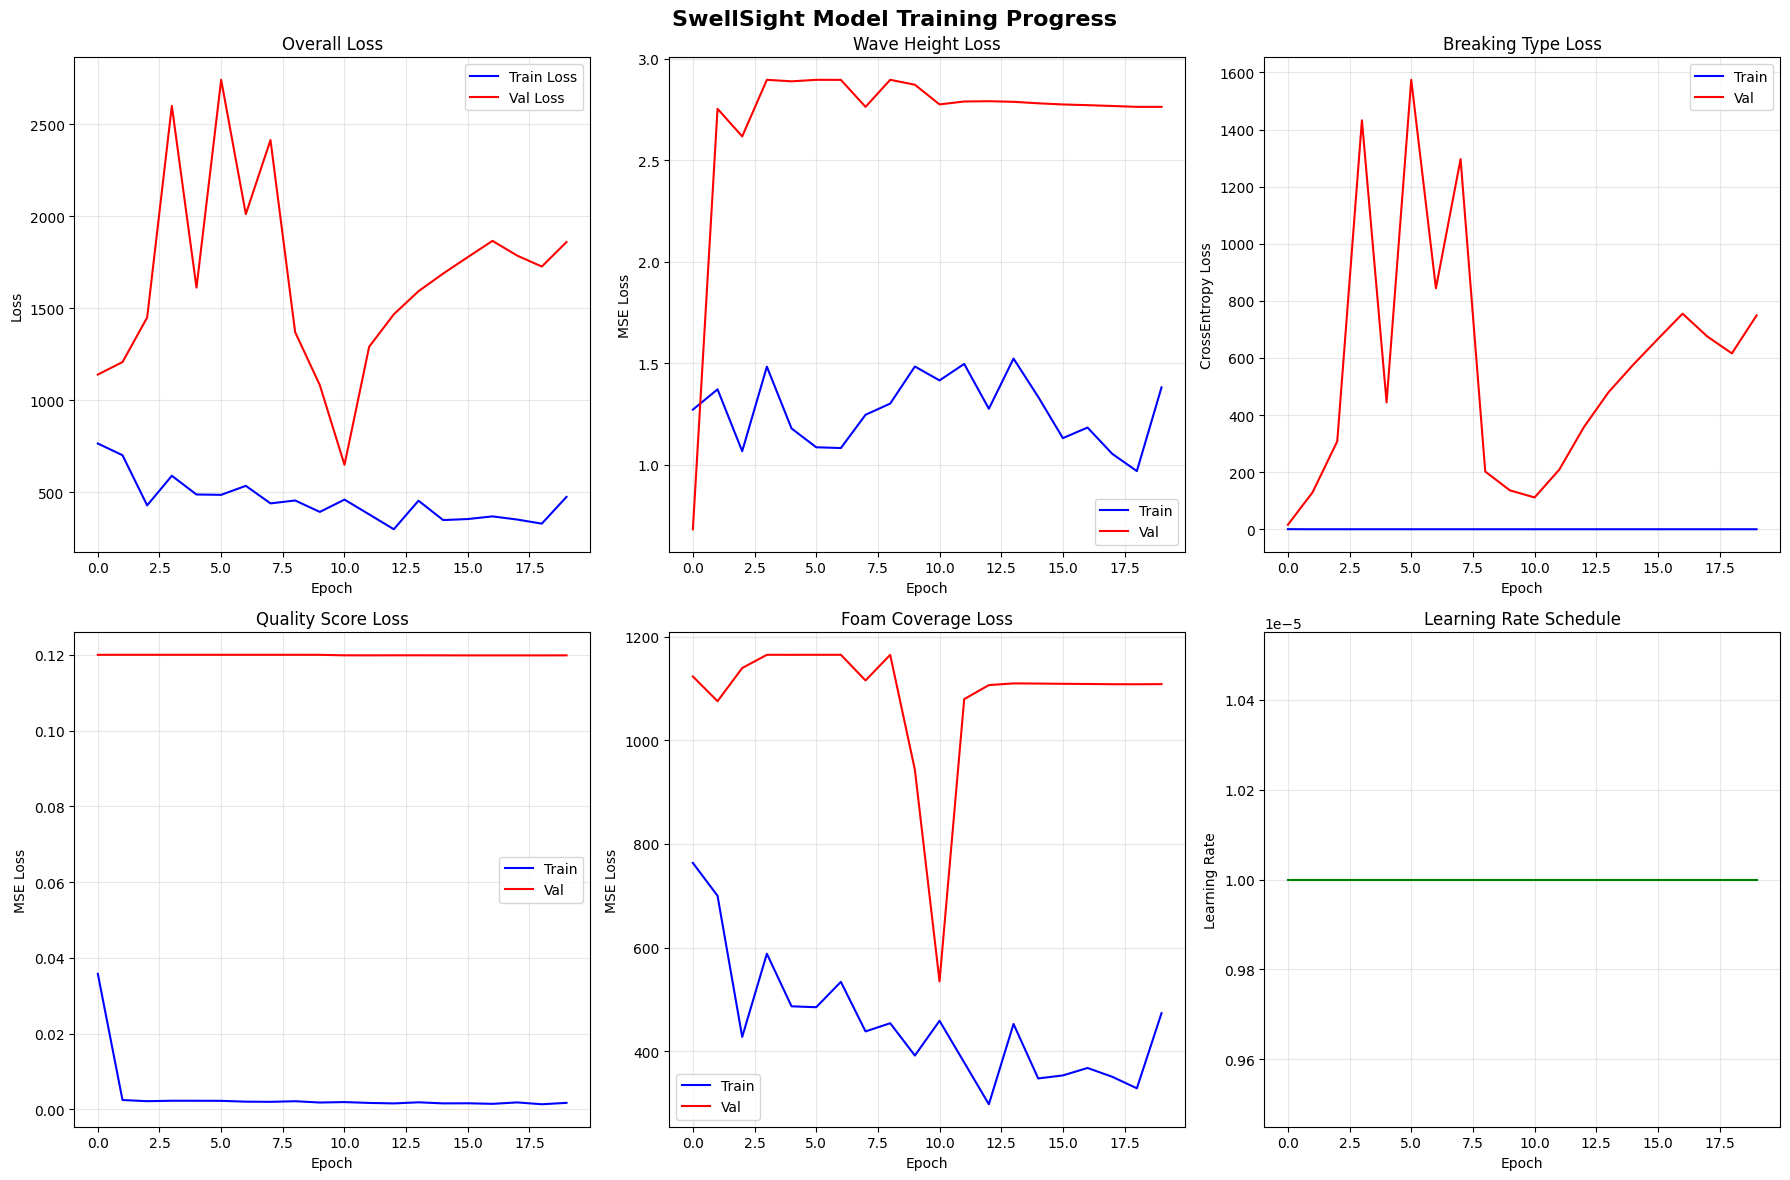


📊 Training Summary:
   Total epochs: 20
   Best validation loss: 648.9283
   Final validation loss: 1860.2122
   Training samples: 48
   Validation samples: 12
   Model checkpoints saved to: /content/drive/MyDrive/SwellSight/models

✅ Model training pipeline completed successfully!


In [12]:
# Save final model
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'training_history': training_history,
    'final_val_loss': val_loss,
    'best_val_loss': best_val_loss,
    'num_epochs': num_epochs,
    'model_config': {
        'input_channels': 3,
        'num_breaking_types': 4,
        'image_size': (224, 224)
    },
    'training_config': {
        'batch_size': 8,
        'learning_rate': 0.001,
        'weight_decay': 1e-4,
        'num_epochs': num_epochs
    }
}

torch.save(final_checkpoint, checkpoint_dir / 'final_model.pth')
print(f"✓ Final model saved: {checkpoint_dir / 'final_model.pth'}")

# Save training results as JSON
training_results = {
    'training_completed': True,
    'completion_time': datetime.now().isoformat(),
    'num_epochs': num_epochs,
    'best_val_loss': best_val_loss,
    'final_val_loss': val_loss,
    'training_samples': len(train_loader.dataset),
    'validation_samples': len(val_loader.dataset),
    'model_checkpoints': {
        'best_model': str(checkpoint_dir / 'best_model.pth'),
        'final_model': str(checkpoint_dir / 'final_model.pth')
    },
    'training_history': training_history
}

results_path = Path(CONFIG['paths']['metadata_path']) / 'model_training_results.json'
with open(results_path, 'w') as f:
    json.dump(training_results, f, indent=2)

print(f"✓ Training results saved: {results_path}")

# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('SwellSight Model Training Progress', fontsize=16, fontweight='bold')

# Overall loss
axes[0, 0].plot(training_history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(training_history['val_loss'], label='Val Loss', color='red')
axes[0, 0].set_title('Overall Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Height loss
axes[0, 1].plot(training_history['train_height_loss'], label='Train', color='blue')
axes[0, 1].plot(training_history['val_height_loss'], label='Val', color='red')
axes[0, 1].set_title('Wave Height Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MSE Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Breaking type loss
axes[0, 2].plot(training_history['train_breaking_loss'], label='Train', color='blue')
axes[0, 2].plot(training_history['val_breaking_loss'], label='Val', color='red')
axes[0, 2].set_title('Breaking Type Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('CrossEntropy Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Quality loss
axes[1, 0].plot(training_history['train_quality_loss'], label='Train', color='blue')
axes[1, 0].plot(training_history['val_quality_loss'], label='Val', color='red')
axes[1, 0].set_title('Quality Score Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Foam coverage loss
axes[1, 1].plot(training_history['train_foam_loss'], label='Train', color='blue')
axes[1, 1].plot(training_history['val_foam_loss'], label='Val', color='red')
axes[1, 1].set_title('Foam Coverage Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MSE Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Learning rate schedule
lr_history = [scheduler.get_last_lr()[0] for _ in range(num_epochs)]
axes[1, 2].plot(lr_history, color='green')
axes[1, 2].set_title('Learning Rate Schedule')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Learning Rate')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Summary:")
print(f"   Total epochs: {num_epochs}")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Final validation loss: {val_loss:.4f}")
print(f"   Training samples: {len(train_loader.dataset)}")
print(f"   Validation samples: {len(val_loader.dataset)}")
print(f"   Model checkpoints saved to: {checkpoint_dir}")
print(f"\n✅ Model training pipeline completed successfully!")